In [1]:
from stochastic_proc.midprice import BrownianMidprice
from stochastic_proc.arrivals import PoissonArrivals
from stochastic_proc.dynamics import LimitOrderDynamics
from envs.trading import TradingEnv
from agents.avellaneda_stoikov import AvellanedaStoikovAgent
from rewards.RewardFunctions import PnLReward, InventoryQuadraticPenalty, SpreadRegularizer, SumReward
from utils.plot_single import run_and_log, plot_single_episode
from utils.plot_batch import simulate_batch, plot_batch

In [2]:
SEED = 7
T, M = 1.0, 200
dt = T / M
N = 256
s0, sigma = 100.0, 2.0
A, k_fill = 140.0, 1.5
gamma = 0.1

mid = BrownianMidprice(s0=s0, sigma=sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(lam_bid=A, lam_ask=A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid_model=mid, arr_model=arr, fill_k=k_fill, max_depth=20.0)

# Risk-averse reward ≈ PnL  -  (0.5*gamma*sigma^2 * q^2 * dt)
inv_pen = InventoryQuadraticPenalty(lam=0.5 * gamma * sigma**2, weight=dt, use_next_q=True)
spread_reg = SpreadRegularizer(alpha=1e-3)
reward = SumReward([PnLReward(), inv_pen, spread_reg], weights=[1.0, 1.0, 1.0])

env = TradingEnv(dynamics=dyn, T=T, M=M, reward_fn=reward, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=gamma)

obs, _ = env.reset()
done = False
cum_r = 0.0
while not done:
    action = agent.get_action(obs)
    obs, r, done, _, info = env.step(action)
    cum_r += r
print("Episode return:", cum_r)


Episode return: 87.09555505111348


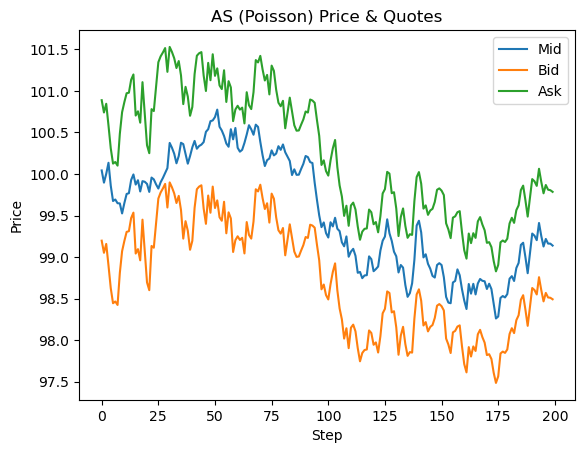

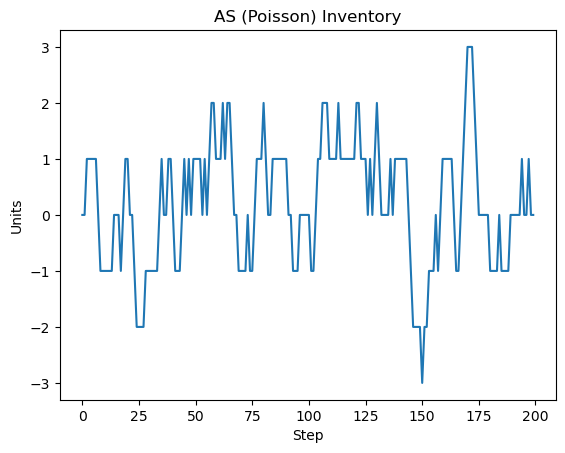

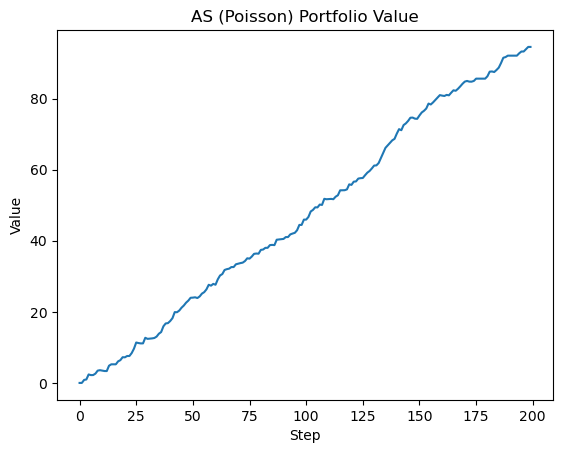

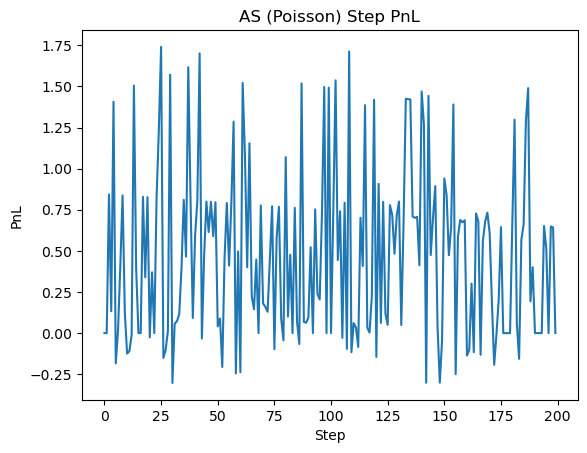

In [3]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)

logs = run_and_log(env, agent)
plot_single_episode(logs, title_prefix="AS (Poisson)")



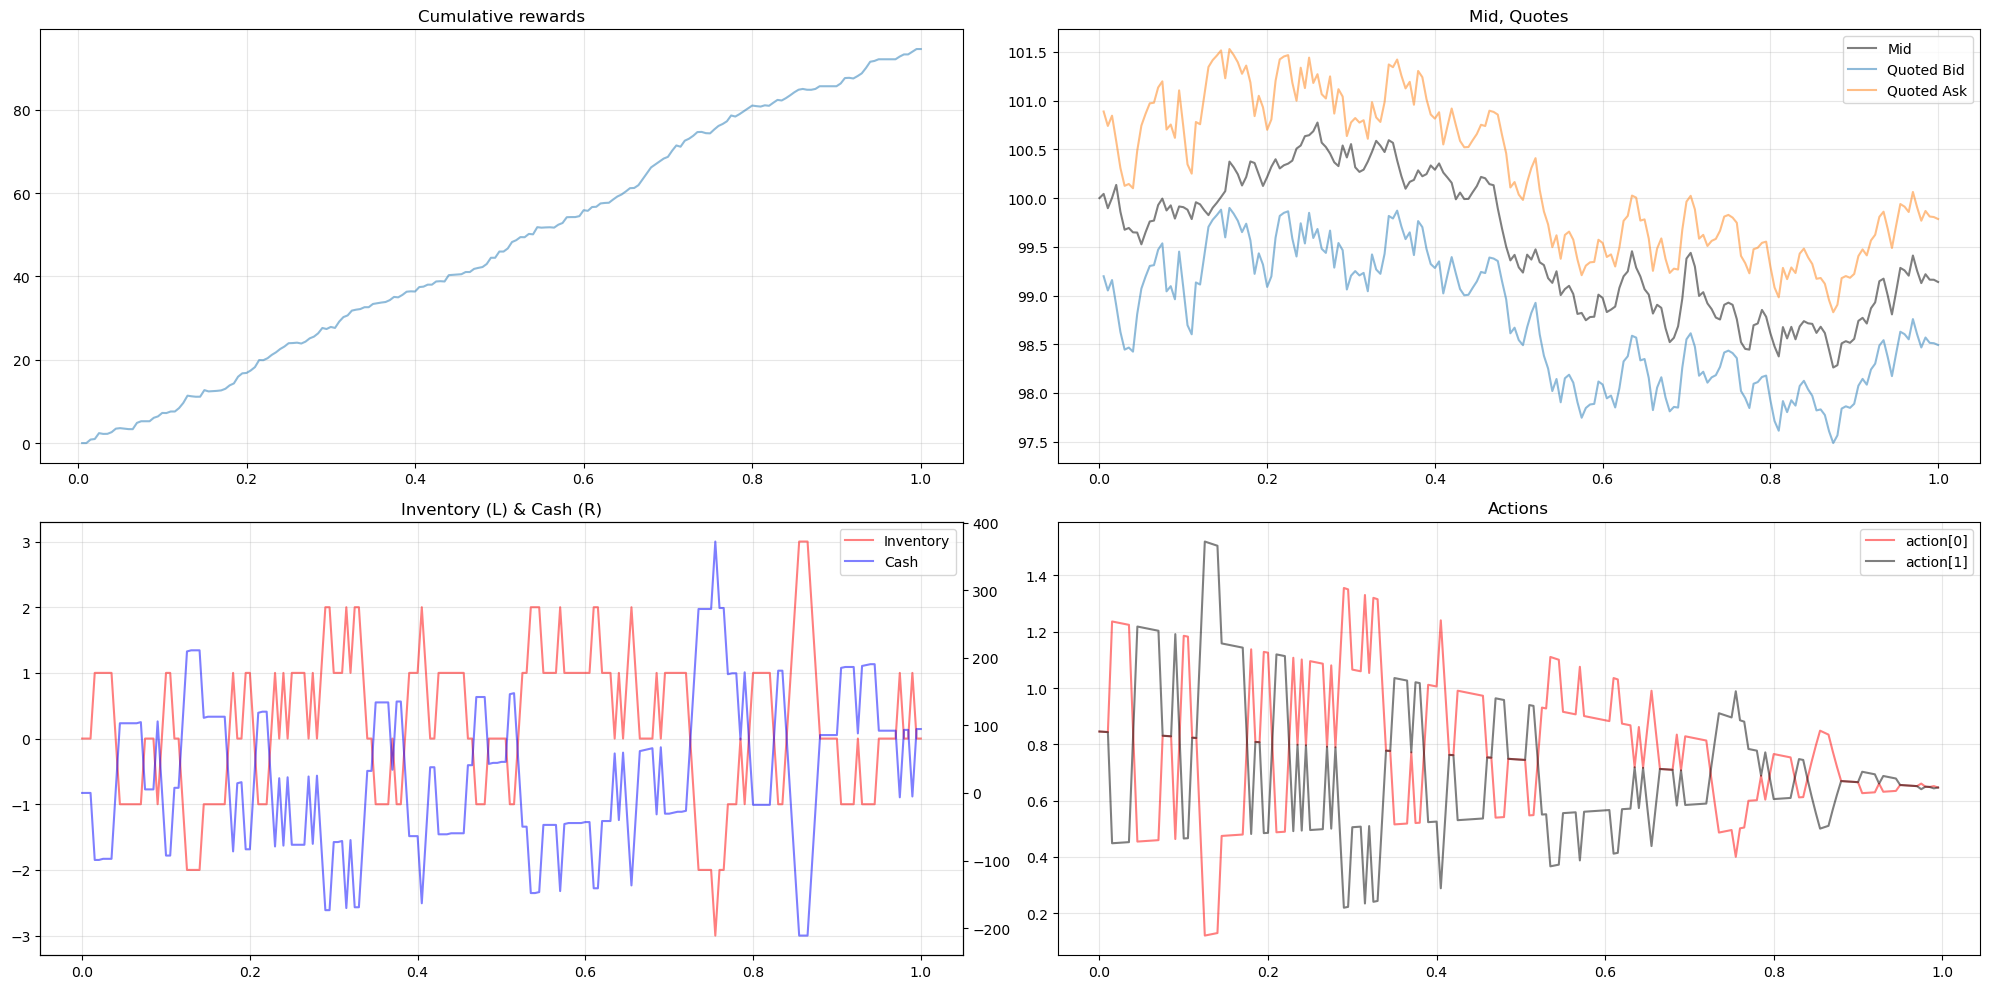

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory    1.492085  93.267929  7.670089               -0.130859   

          Std terminal inventory  
Inventory                2.97917  


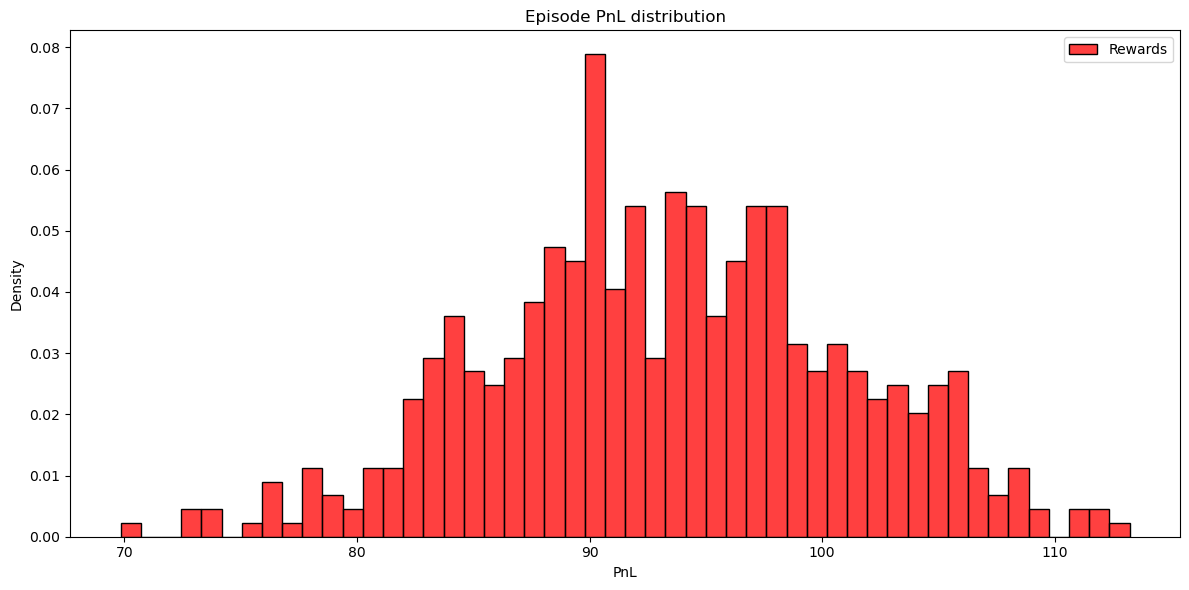

In [11]:
from utils.plot_lite import plot_trajectory, generate_results_table_and_hist

SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent = AvellanedaStoikovAgent(env, gamma=0.1)
plot_trajectory(env, agent, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent = AvellanedaStoikovAgent(env_vec, gamma=0.1)
results, fig, totals = generate_results_table_and_hist(env_vec, agent)
print(results)

Infinite horizon

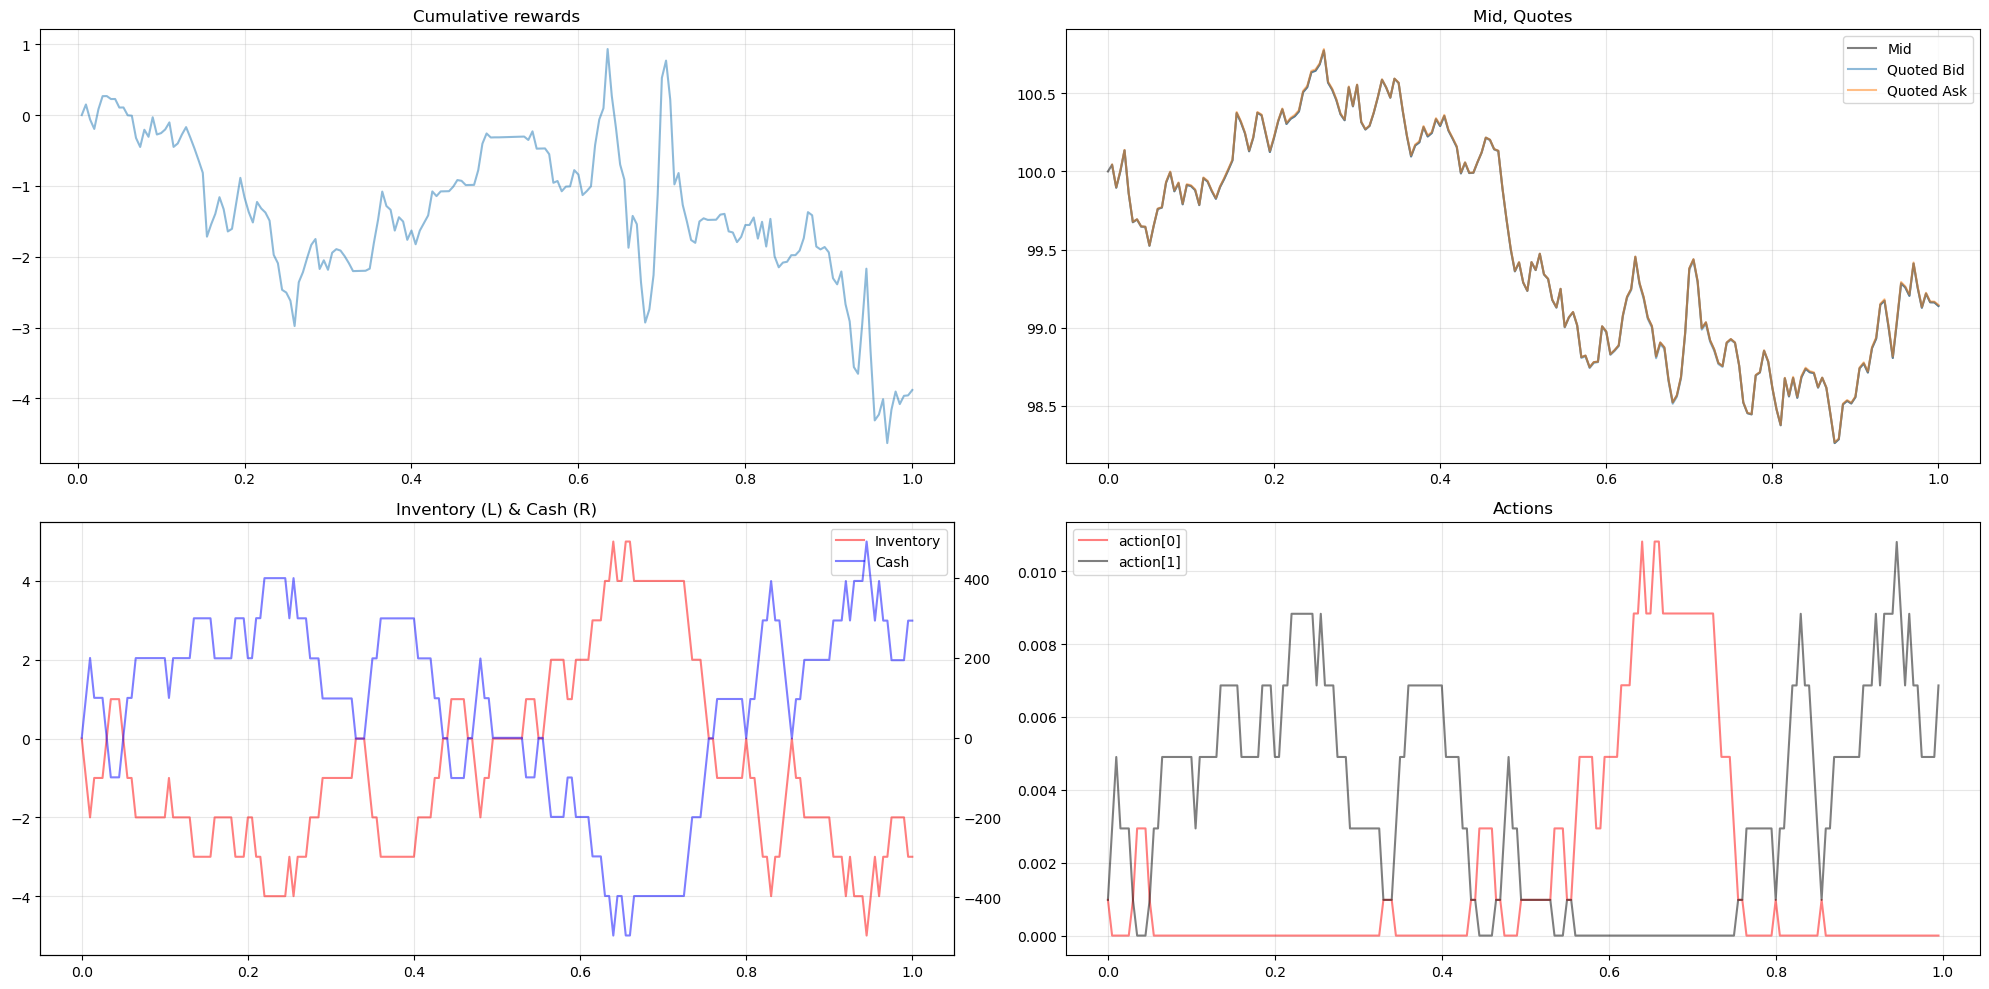

          Mean spread  Mean PnL    Std PnL Mean terminal inventory  \
Inventory     0.01109  1.533453  13.588725                0.050781   

          Std terminal inventory  
Inventory               9.781068  


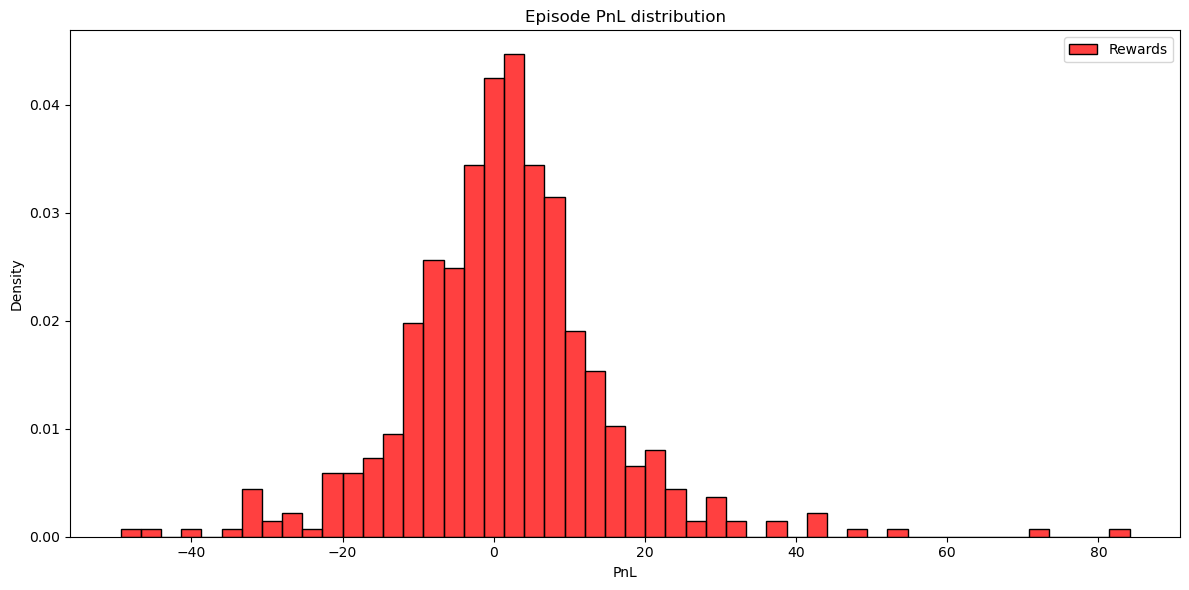

In [12]:
SEED, T, M, s0, sigma, A, k_fill, N = 42, 1.0, 200, 100.0, 2.0, 140.0, 1.5, 1
dt = T / M
mid = BrownianMidprice(s0, sigma, num_traj=N, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=N, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)

# Single-trajectory plotting (RL-style)
env = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=False)
agent_inf = AvellanedaStoikovAgent(env, gamma=0.1, mode="infinite", q_max=100)
plot_trajectory(env, agent_inf, show_reservation=False)

# Batch stats & PnL hist (vectorized episode)
mid = BrownianMidprice(s0, sigma, num_traj=512, dt=dt, T=T, seed=SEED)
arr = PoissonArrivals(A, A, num_traj=512, dt=dt, T=T, seed=SEED)
dyn = LimitOrderDynamics(mid, arr, fill_k=k_fill, max_depth=20.0)
env_vec = TradingEnv(dynamics=dyn, T=T, M=M, seed=SEED, return_vectorized=True)
agent_inf = AvellanedaStoikovAgent(env_vec, gamma=0.1, mode="infinite", q_max=100)
results, fig, totals = generate_results_table_and_hist(env_vec, agent_inf)
print(results)